In [5]:
#pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317130 sha256=9e80c9c923c34418b8a647f982a647c982c6b65fe839b3ad759c14229aad86d0
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark


In [6]:
pip install findspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
import findspark
findspark.init()

In [8]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("CBPC") \
    .getOrCreate()


In [9]:

# Caminho do arquivo CSV
caminho_arquivo = '/content/campeonato-brasileiro-pontos-corridos-2003-2020-jogos.csv'

# Carrega o arquivo CSV em um DataFrame do Spark
df = spark.read.csv(caminho_arquivo, sep=';') 

# Exibe o DataFrame 
df.show(truncate=False)

+------+----------+-------+-------+-------------+-------------+-------------+-------------------+---------------+----------------+---------------+----------------+---------------+
|_c0   |_c1       |_c2    |_c3    |_c4          |_c5          |_c6          |_c7                |_c8            |_c9             |_c10           |_c11            |_c12           |
+------+----------+-------+-------+-------------+-------------+-------------+-------------------+---------------+----------------+---------------+----------------+---------------+
|Rodada|Data      |Horário|Dia    |Mandante     |Visitante    |Vencedor     |Arena              |Mandante Placar|Visitante Placar|Estado Mandante|Estado Visitante|Estado Vencedor|
|1     |29/03/2003|16h00  |Sábado |Athlético-PR |Grêmio       |Athlético-PR |Arena da Baixada   |2              |0               |PR             |RS              |PR             |
|1     |29/03/2003|16h00  |Sábado |Guarani      |Vasco        |Guarani      |Brinco de Ouro     |4  

In [ ]:
total_partidas = df.count() - 1  # Descontando a linha de cabeçalho
print("Total de partidas:", total_partidas)


Total de partidas: 7266


In [ ]:
from pyspark.sql.functions import abs

# Partida com maior diferença de placar
maior_diferenca = df.filter(df['_c8'] != '-') \
    .filter(df['_c9'] != '-') \
    .withColumn('Diferenca_Gols', abs(df['_c8'] - df['_c9'])) \
    .orderBy('Diferenca_Gols', ascending=False) \
    .first()

print("Partida com maior diferença de placar:")
print("Mandante:", maior_diferenca['_c4'])
print("Visitante:", maior_diferenca['_c5'])
print("Placar:", maior_diferenca['_c8'], "-", maior_diferenca['_c9'])
print("Diferença de gols:", maior_diferenca['Diferenca_Gols'])


Partida com maior diferença de placar:
Mandante: Goiás
Visitante: Juventude
Placar: 7 - 0
Diferença de gols: 7.0


In [10]:
from pyspark.sql.functions import col
# Lista o time com maior número de vitórias em 20 anos
time_mais_vitorioso = df.filter(col('_c6') != '-') \
    .groupBy('_c6') \
    .count() \
    .orderBy('count', ascending=False) \
    .withColumnRenamed('count', 'Total_Vitorias')

time_mais_vitorioso.show()



+-------------+--------------+
|          _c6|Total_Vitorias|
+-------------+--------------+
|    São Paulo|           327|
|       Santos|           304|
|     Flamengo|           295|
|Internacional|           292|
|     Cruzeiro|           291|
|       Grêmio|           283|
|  Corinthians|           281|
|   Fluminense|           269|
|  Atlético-MG|           267|
| Athlético-PR|           266|
|    Palmeiras|           266|
|  Botafogo-RJ|           213|
|        Vasco|           196|
|        Goiás|           189|
|     Coritiba|           169|
|  Figueirense|           142|
|      Vitória|           123|
|        Sport|           122|
|  Ponte Preta|           114|
|        Bahia|           104|
+-------------+--------------+
only showing top 20 rows



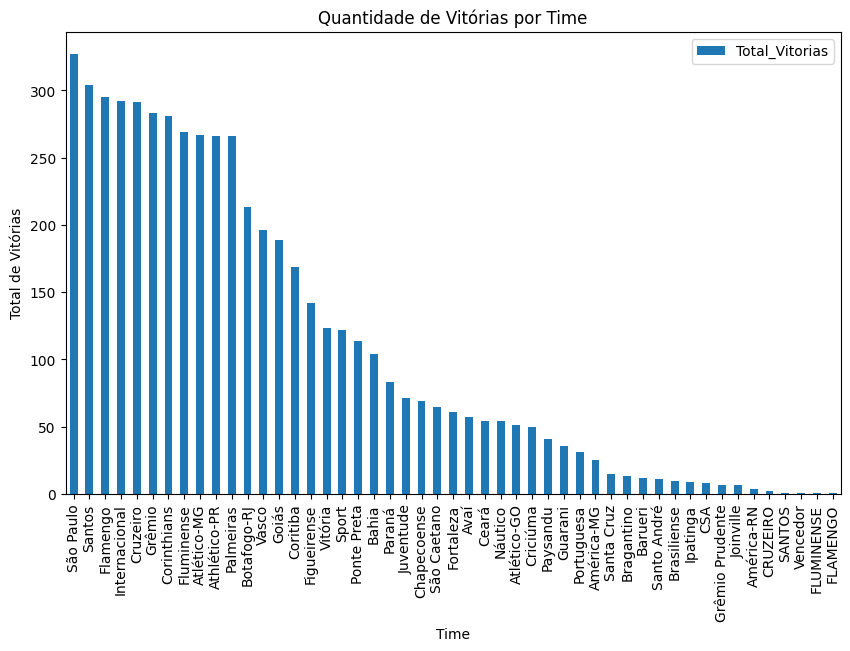

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Converter o DataFrame para um objeto Pandas
df_pandas = time_mais_vitorioso.toPandas()

# Plotar o gráfico de barras
df_pandas.plot(kind='bar', x='_c6', y='Total_Vitorias', figsize=(10, 6))

# Configurar os rótulos e o título do gráfico
plt.xlabel('Time')
plt.ylabel('Total de Vitórias')
plt.title('Quantidade de Vitórias por Time')

# Exibir o gráfico
plt.show()


In [ ]:
from pyspark.sql.functions import split, col

# Input contendo os dados do jogo
dados_campeonato_br = "1;29/03/2003;16h00;Sábado;Athlético-PR;Grêmio;Athlético-PR;Arena da Baixada;2;0;PR;RS;PR"

# Convertendo a string em uma lista para ser usada como dados de entrada
dados_jogo = [dados_campeonato_br]

# Cria um DataFrame a partir da lista de dados
df = spark.createDataFrame(dados_jogo, "string")

# Divide a coluna em partes separadas por ";"
df = df.withColumn("dados_separados", split(df.value, ";"))

# Extrair as colunas individuais a partir da coluna "dados_separados"
df = df.selectExpr("dados_separados[0] as rodada",
                   "dados_separados[1] as data",
                   "dados_separados[2] as horario",
                   "dados_separados[3] as dia",
                   "dados_separados[4] as mandante",
                   "dados_separados[5] as visitante",
                   "dados_separados[6] as vencedor",
                   "dados_separados[7] as arena",
                   "CAST(dados_separados[8] AS INT) as mandante_placar",
                   "CAST(dados_separados[9] AS INT) as visitante_placar",
                   "dados_separados[10] as estado_mandante",
                   "dados_separados[11] as estado_visitante",
                   "dados_separados[12] as estado_vencedor")

# Realiza as análises desejadas
df.show()

# Calcula a diferença de gols entre o mandante e o visitante
df = df.withColumn("diferenca_gols", col("mandante_placar") - col("visitante_placar"))

# Imprime o resultado
df.select("mandante", "visitante", "diferenca_gols").show()


+------+----------+-------+------+------------+---------+------------+----------------+---------------+----------------+---------------+----------------+---------------+
|rodada|      data|horario|   dia|    mandante|visitante|    vencedor|           arena|mandante_placar|visitante_placar|estado_mandante|estado_visitante|estado_vencedor|
+------+----------+-------+------+------------+---------+------------+----------------+---------------+----------------+---------------+----------------+---------------+
|     1|29/03/2003|  16h00|Sábado|Athlético-PR|   Grêmio|Athlético-PR|Arena da Baixada|              2|               0|             PR|              RS|             PR|
+------+----------+-------+------+------------+---------+------------+----------------+---------------+----------------+---------------+----------------+---------------+

+------------+---------+--------------+
|    mandante|visitante|diferenca_gols|
+------------+---------+--------------+
|Athlético-PR|   Grêmio|     

In [ ]:
from pyspark.sql.functions import col

# Contagem de jogos entre cada par de times
confrontos = df.groupBy('_c4', '_c5').count().withColumnRenamed('_c4', 'Time_A').withColumnRenamed('_c5', 'Time_B')

# Encontrar o par de times com o maior número de confrontos
mais_confrontos = confrontos.orderBy(col('count').desc()).first()

# Extrair os times com o maior número de confrontos
time_a = mais_confrontos['Time_A']
time_b = mais_confrontos['Time_B']
numero_confrontos = mais_confrontos['count']

print(f"Os times que se confrontaram mais vezes foram: {time_a} e {time_b}, com um total de {numero_confrontos} confrontos.")


Os times que se confrontaram mais vezes foram: São Paulo e Santos, com um total de 18 confrontos.


In [ ]:
from pyspark.sql.functions import col

# Contagem de vitórias por clube
contagem_vitorias = df.groupBy("_c6").agg(count("_c6").alias("Total de Vitórias"))
contagem_vitorias = contagem_vitorias.orderBy("Total de Vitórias", ascending=False)


In [ ]:
# Obter os clubes com mais vitórias
clubes_mais_vitorias = contagem_vitorias.select("_c6").limit(10).rdd.flatMap(lambda x: x).collect()


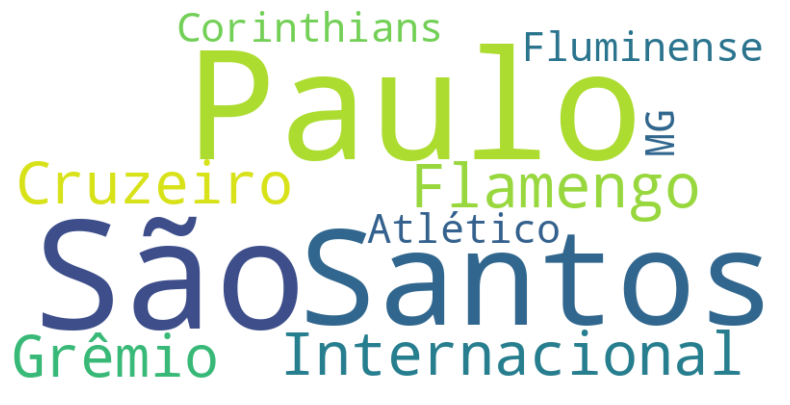

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Criar a nuvem de palavras
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(" ".join(clubes_mais_vitorias))

# Exibir a nuvem de palavras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()
